Initial Shape: (6435, 8)
   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-05-02    1643690.90             0        42.31       2.572   
1      1 2010-12-02    1641957.44             1        38.51       2.548   
2      1        NaT    1611968.17             0        39.93       2.514   
3      1        NaT    1409727.59             0        46.63       2.561   
4      1 2010-05-03    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
Shape after cleaning: (6435, 8)

Summary Statistics:
             Store                           Date  Weekly_Sales  Holiday_Flag  \
count  6435.000000                           2565  6.435000e+03   6435.000000   
mean     23.000000  2011-05-29 11:47:22.105263104  1.046965e+06      0.069930   
min       1.000000            2010-01-10 0

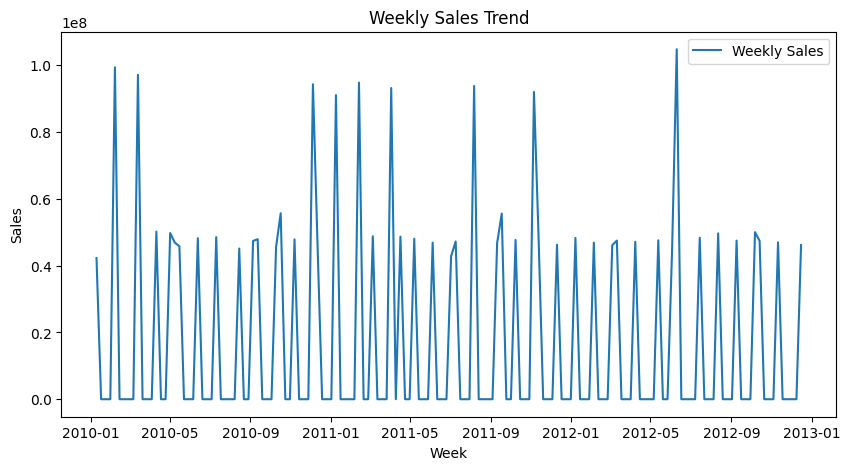

C:\Users\YUSUF\AppData\Local\Temp\ipykernel_4868\691505083.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_store.index, y=top_store.values, palette="Blues_d")


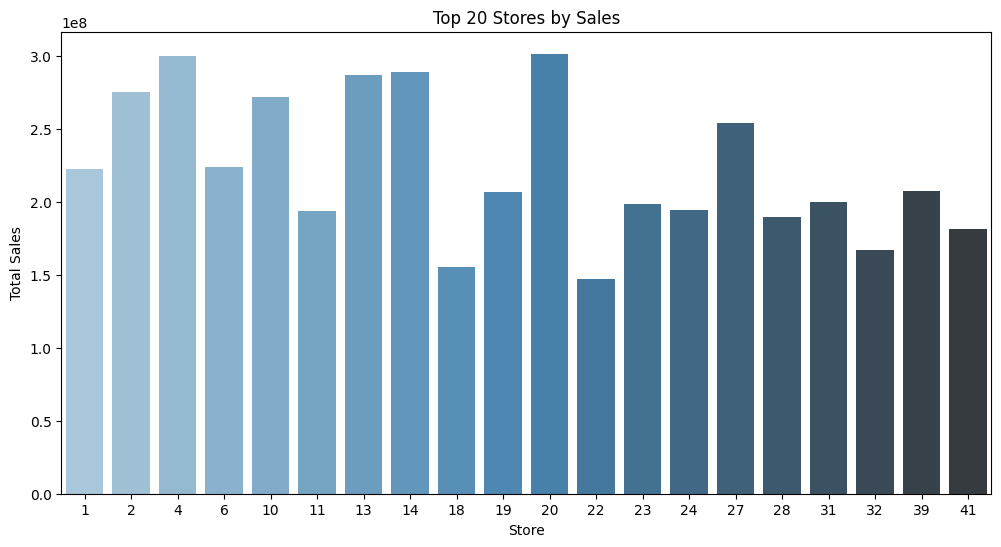

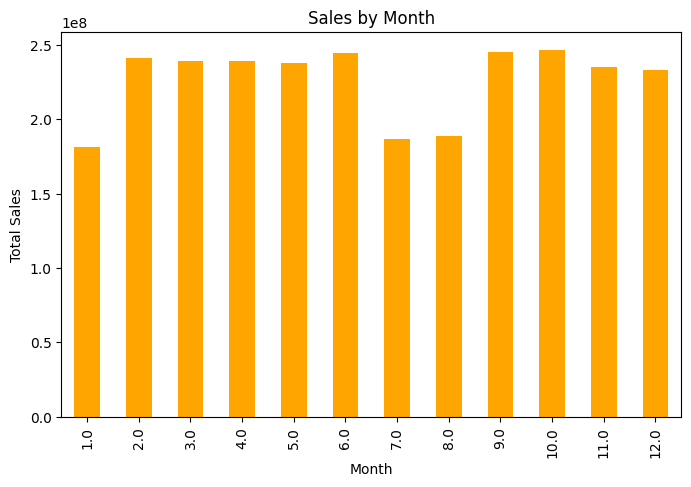

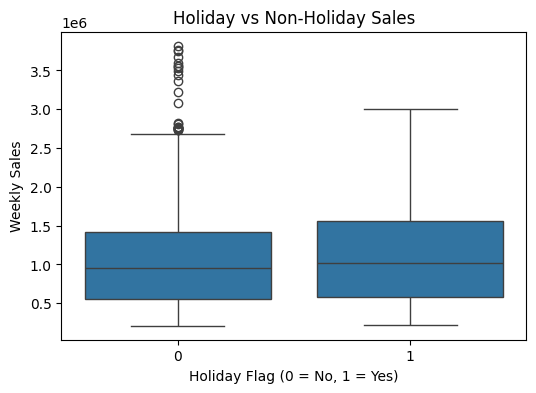

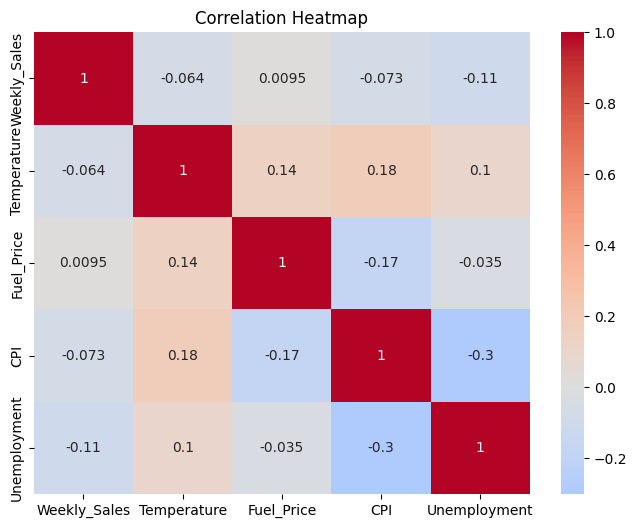

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Dataset

df = pd.read_csv("Walmart.csv")
df.columns = df.columns.str.strip()

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

print("Initial Shape:", df.shape)
print(df.head())

# 2. Data Cleaning

# Convert numeric fields
for col in ['Weekly_Sales','Fuel_Price','Temperature','CPI','Unemployment']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle Holiday_Flag as binary
if 'Holiday_Flag' in df.columns:
    df['Holiday_Flag'] = pd.to_numeric(df['Holiday_Flag'], errors='coerce').fillna(0).astype(int)
    df['Holiday_Flag'] = df['Holiday_Flag'].clip(0,1)

# Handle missing values → median imputation (by Store)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'Store':
        df[col] = df.groupby('Store')[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].fillna(df[col].median())

print("Shape after cleaning:", df.shape)


# 3. Feature Engineering

df['day_of_week'] = df['Date'].dt.day_name()

df['month'] = df['Date'].dt.month
df['is_weekend'] = (df['Date'].dt.weekday >= 5).astype(int)

def month_to_season(m):
    if m in [12,1,2]:
        return "Winter"
    elif m in [3,4,5]:
        return "Spring"
    elif m in [6,7,8]:
        return "Summer"
    else:
        return "Fall"

df['season'] = df['month'].apply(month_to_season)

# Save cleaned dataset
#df.to_csv("walmart_clean.csv", index=False)


# 4. Exploratory Data Analysis (EDA)


# --- A. Summary Stats ---
print("\nSummary Statistics:")
print(df.describe())

# --- B. Weekly Sales Trend ---
if 'Weekly_Sales' in df.columns:
    ts = df.dropna(subset=['Date','Weekly_Sales']).set_index('Date').sort_index()
    weekly = ts['Weekly_Sales'].resample('W').sum()

    plt.figure(figsize=(10,5))
    plt.plot(weekly.index, weekly.values, label="Weekly Sales")
    plt.title("Weekly Sales Trend")
    plt.xlabel("Week")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

# --- C. Sales by Store ---
if 'Store' in df.columns and 'Weekly_Sales' in df.columns:
    top_store = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(20)
    plt.figure(figsize=(12,6))
    sns.barplot(x=top_store.index, y=top_store.values, palette="Blues_d")
    plt.title("Top 20 Stores by Sales")
    plt.xlabel("Store")
    plt.ylabel("Total Sales")
    plt.show()

# --- D. Sales by Month ---
if 'month' in df.columns and 'Weekly_Sales' in df.columns:
    month_sales = df.groupby('month')['Weekly_Sales'].sum()
    plt.figure(figsize=(8,5))
    month_sales.plot(kind='bar', color='orange')
    plt.title("Sales by Month")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.show()

# --- E. Holiday vs Non-Holiday Sales ---
if 'Holiday_Flag' in df.columns and 'Weekly_Sales' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
    plt.title("Holiday vs Non-Holiday Sales")
    plt.xlabel("Holiday Flag (0 = No, 1 = Yes)")
    plt.ylabel("Weekly Sales")
    plt.show()

# --- F. Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(df[['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()
